In [3]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [28]:
#get directories and open separated datasets

time_interval = 15 #sec/frame

lmax = 10


datadir = 'E:/Aaron/Combined_iSIM_PCA/'
savedir = datadir
if not os.path.exists(savedir):
    os.makedirs(savedir)

TotalFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

nbins = np.max(FullFrame[[x for x in FullFrame.columns.to_list() if 'bin' in x]].to_numpy())

#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

#limit data to the 30C Galv experiments
TotalFrame['Experiment'] = pd.Categorical(TotalFrame.Experiment.to_list(), categories=['Chemotaxis','Galvanotaxis'], ordered=True)
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=['Random','Chem_Directed','Galv_Directed'], ordered=True)


In [29]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


In [33]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Treatment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z','Temperature'])
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        # Performing two-way ANOVA 
        model = ols(f'{c} ~ C(Treatment) + C(Experiment) + C(Treatment):C(Experiment)', 
                    data=ModeFrame).fit() 
        result = sm.stats.anova_lm(model, type=2) 


        if any(result['PR(>F)'].values <0.05):
            # Print the result 
            print(c, result) 
            siglist.append(c) 


Cell_Volume                                  df        sum_sq       mean_sq           F  \
C(Treatment)                    2.0  3.276799e+07  1.638400e+07  219.593935   
C(Experiment)                   1.0  3.648981e+07  3.648981e+07  489.071250   
C(Treatment):C(Experiment)      2.0  4.243151e+04  2.121575e+04    0.284354   
Residual                    10045.0  7.494617e+08  7.461042e+04         NaN   

                                   PR(>F)  
C(Treatment)                 4.545409e-94  
C(Experiment)               7.423162e-106  
C(Treatment):C(Experiment)   7.525065e-01  
Residual                              NaN  
Cell_Volume_Front                                  df        sum_sq       mean_sq           F  \
C(Treatment)                    2.0  1.018816e+07  5.094080e+06  198.523161   
C(Experiment)                   1.0  1.342793e+07  1.342793e+07  523.304607   
C(Treatment):C(Experiment)      2.0  2.976792e+04  1.488396e+04    0.580048   
Residual                    10045.0  2

PC5                                  df        sum_sq     mean_sq          F  \
C(Treatment)                    2.0    385.496216  192.748108  30.301173   
C(Experiment)                   1.0    197.324297  197.324297  31.020578   
C(Treatment):C(Experiment)      2.0     35.442079   17.721039   2.785855   
Residual                    10045.0  63897.022436    6.361077        NaN   

                                  PR(>F)  
C(Treatment)                7.584122e-14  
C(Experiment)               2.618808e-08  
C(Treatment):C(Experiment)  6.172399e-02  
Residual                             NaN  
PC6                                  df        sum_sq    mean_sq         F  \
C(Treatment)                    2.0     53.714115  26.857058  4.695148   
C(Experiment)                   1.0      0.128787   0.128787  0.022515   
C(Treatment):C(Experiment)      2.0      1.348109   0.674054  0.117838   
Residual                    10045.0  57459.135760   5.720173       NaN   

                         

In [15]:
#get the number of images of cells and unique cells per migration mode
samplesize = pd.DataFrame([])

for m, mod in TotalFrame.groupby('Treatment'):
    imnum = len(mod)
    cellnum = len(mod.CellID.unique())
    samplesize = samplesize.append(pd.DataFrame({'Treatment':m,
                                                 'Cells':cellnum, 
                                                'Images':imnum}, index = [0]))

samplesize = samplesize.reset_index(drop=True)
samplesize

,Migration_Mode,Cells,Images
0,Random,242,11538
1,Pre-Galvanotaxis,108,1658
2,Galvanotaxis,236,10744


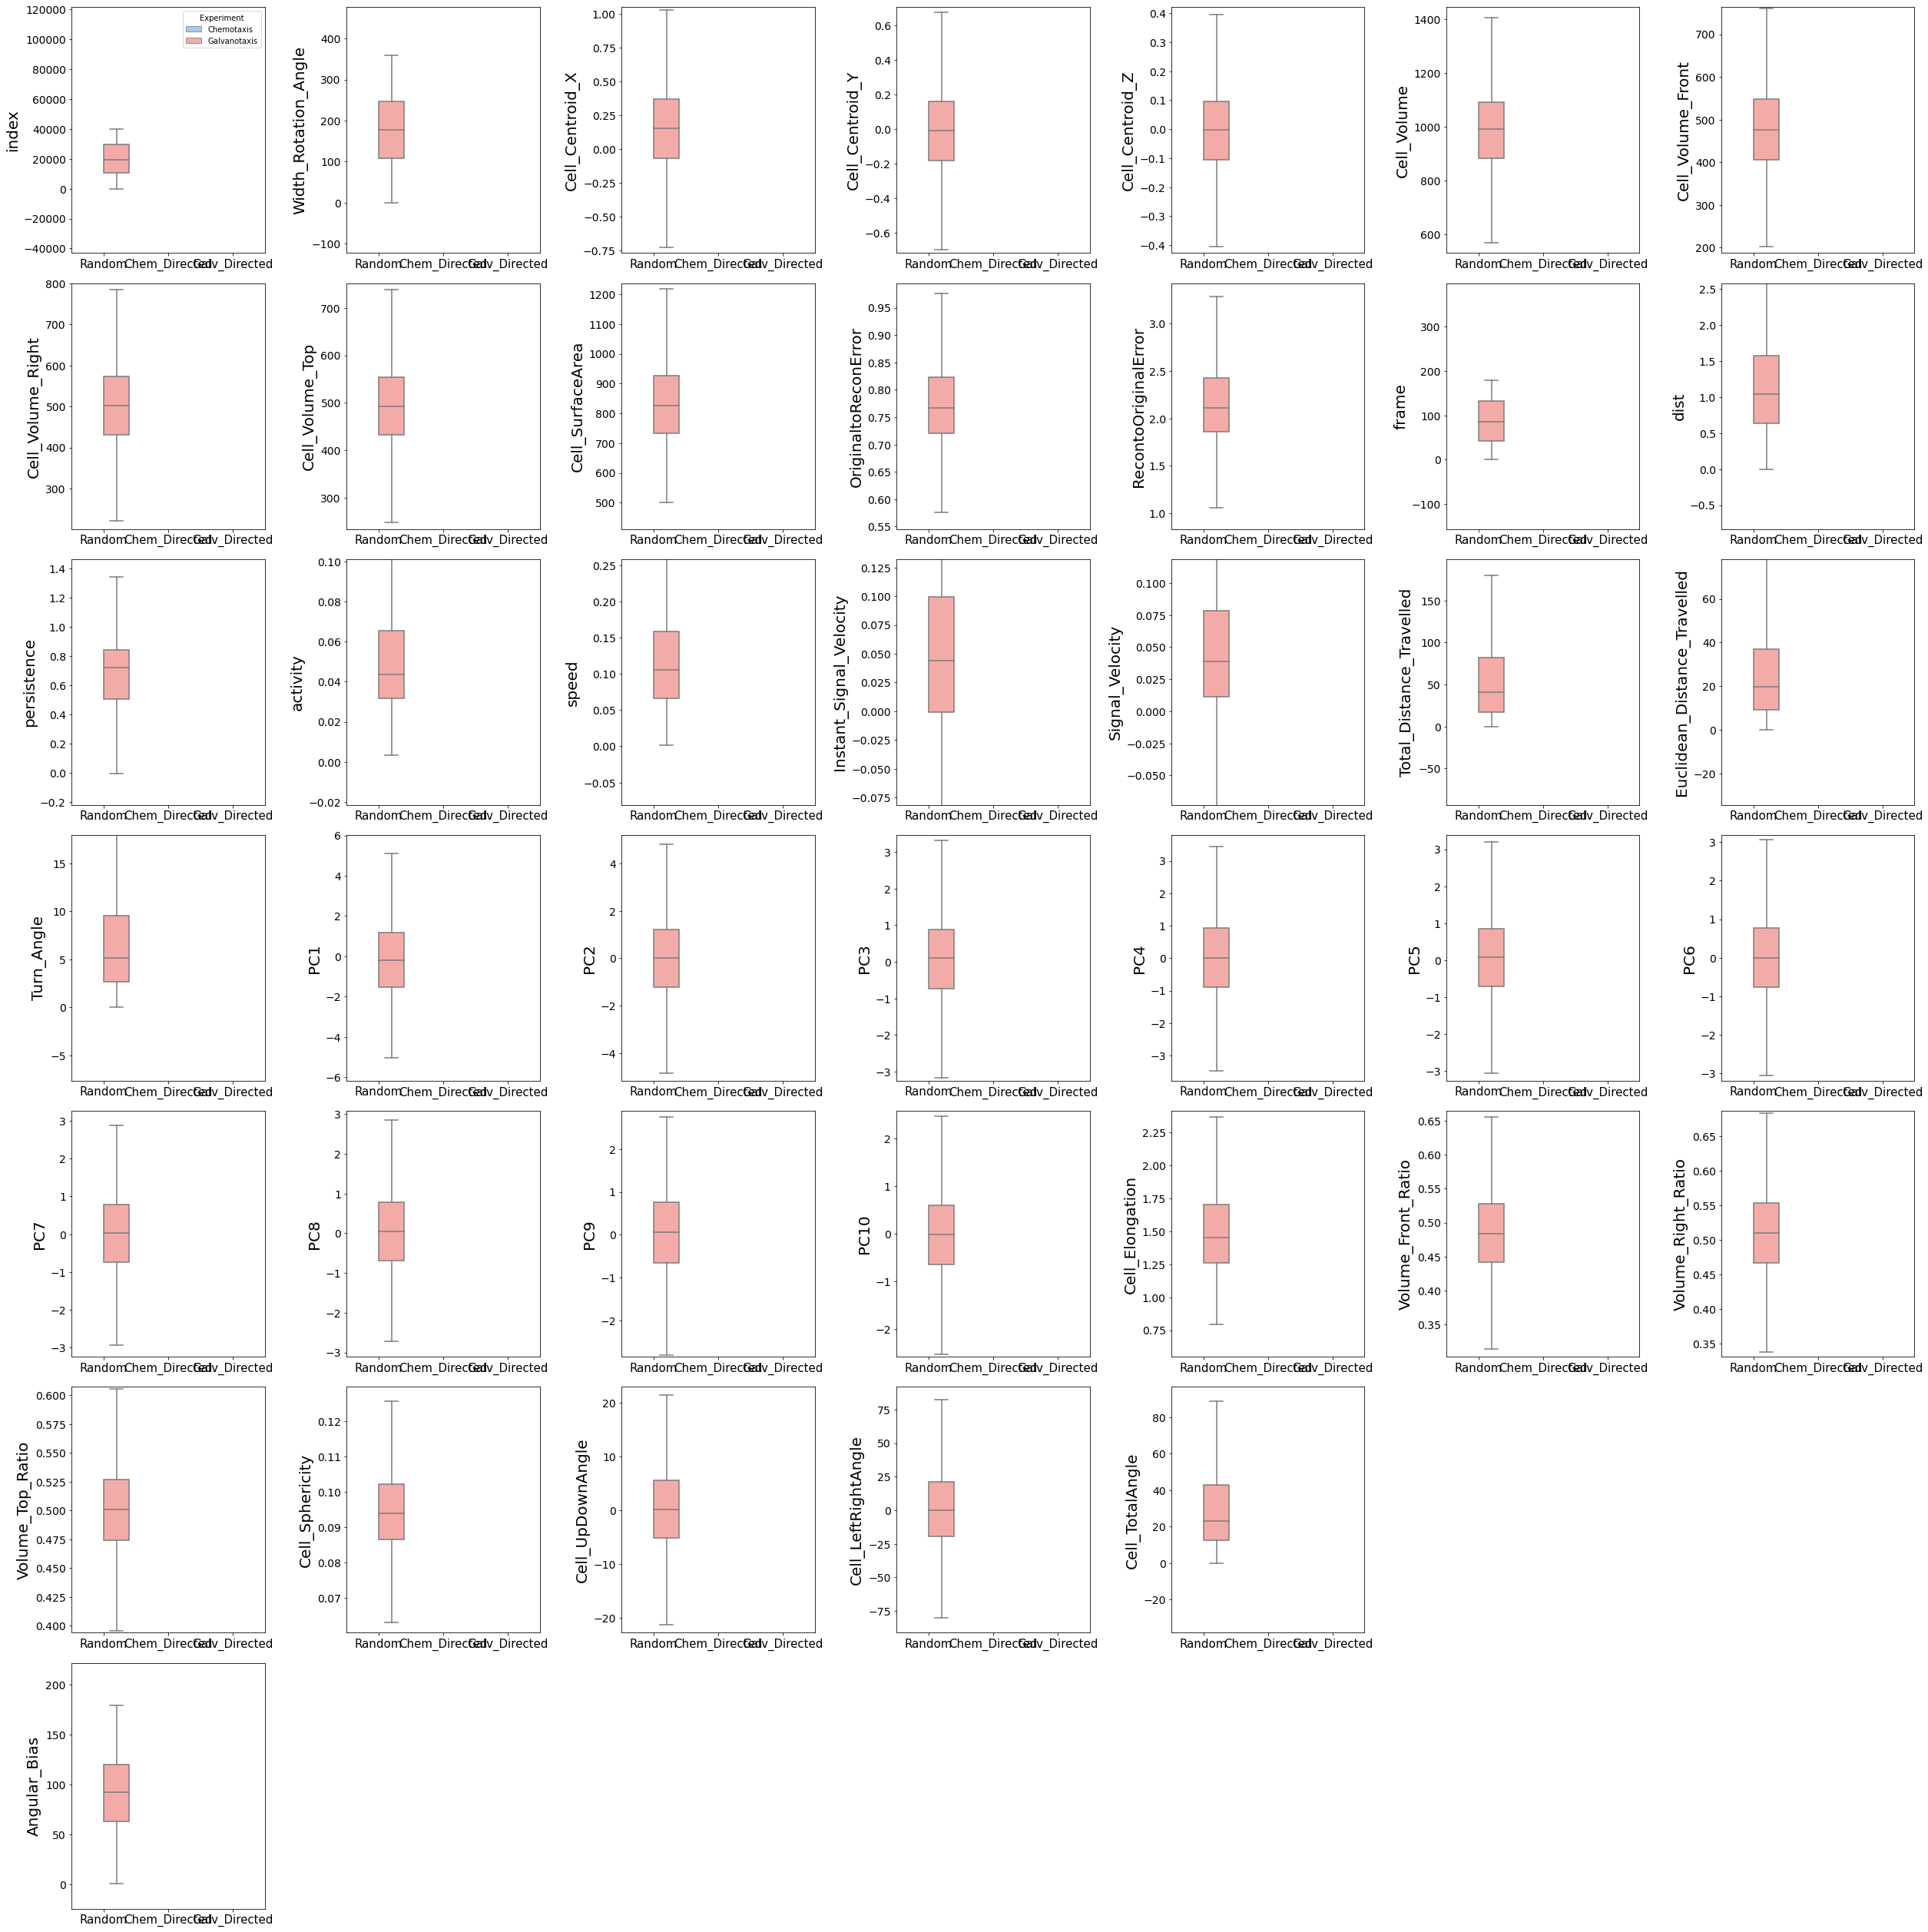

In [22]:
############### box plot comparisons of all stats ##########################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles



############## graph all of the stats for 30C #########
moreremove = []
moreremove.extend([i for i in TotalFrame.columns.to_list() if 'Euler' in i])
moreremove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
moreremove.extend([i for i in TotalFrame.columns.to_list() if 'avg' in i])
moreremove.extend(['cell','CellID','structure','x','y','z','Experiment_Number','Date','Temperature'])
ModeFrame = TotalFrame.copy().drop(columns=to_remove+moreremove).reset_index()

#make subplots
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]
sp = math.ceil(math.sqrt(len(ModeFrame.columns)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))
for i, ax in enumerate(axes.flatten()):
    if (i<len(ModeFrame.columns.to_list())) and (ModeFrame.columns.to_list()[i] not in ['Treatment','Experiment']):
        param = ModeFrame.columns.to_list()[i]
        bp = sns.boxplot(data=ModeFrame, x='Treatment', y=param, hue = 'Experiment', palette = colorlist,# width = 0.15, 
                fliersize=0, boxprops={'zorder': 2}, ax=ax)
        Q1 = ModeFrame[param].quantile(0.25)
        Q3 = ModeFrame[param].quantile(0.75)  
        IQR = Q3 - Q1
        ax.set_ylim(Q1 - 1.6*IQR, Q3 + 1.6*IQR)
        ax.set_ylabel(param, fontsize=20)
        ax.set_xlabel('', fontsize=20)
        ax.tick_params('y', labelsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
        if i>0:
            ax.legend_ = None
    else:
        ax.remove()

    
plt.tight_layout()
plt.savefig(datadir + 'Treatment and Experiment comparison metric boxes.png', bbox_inches='tight')



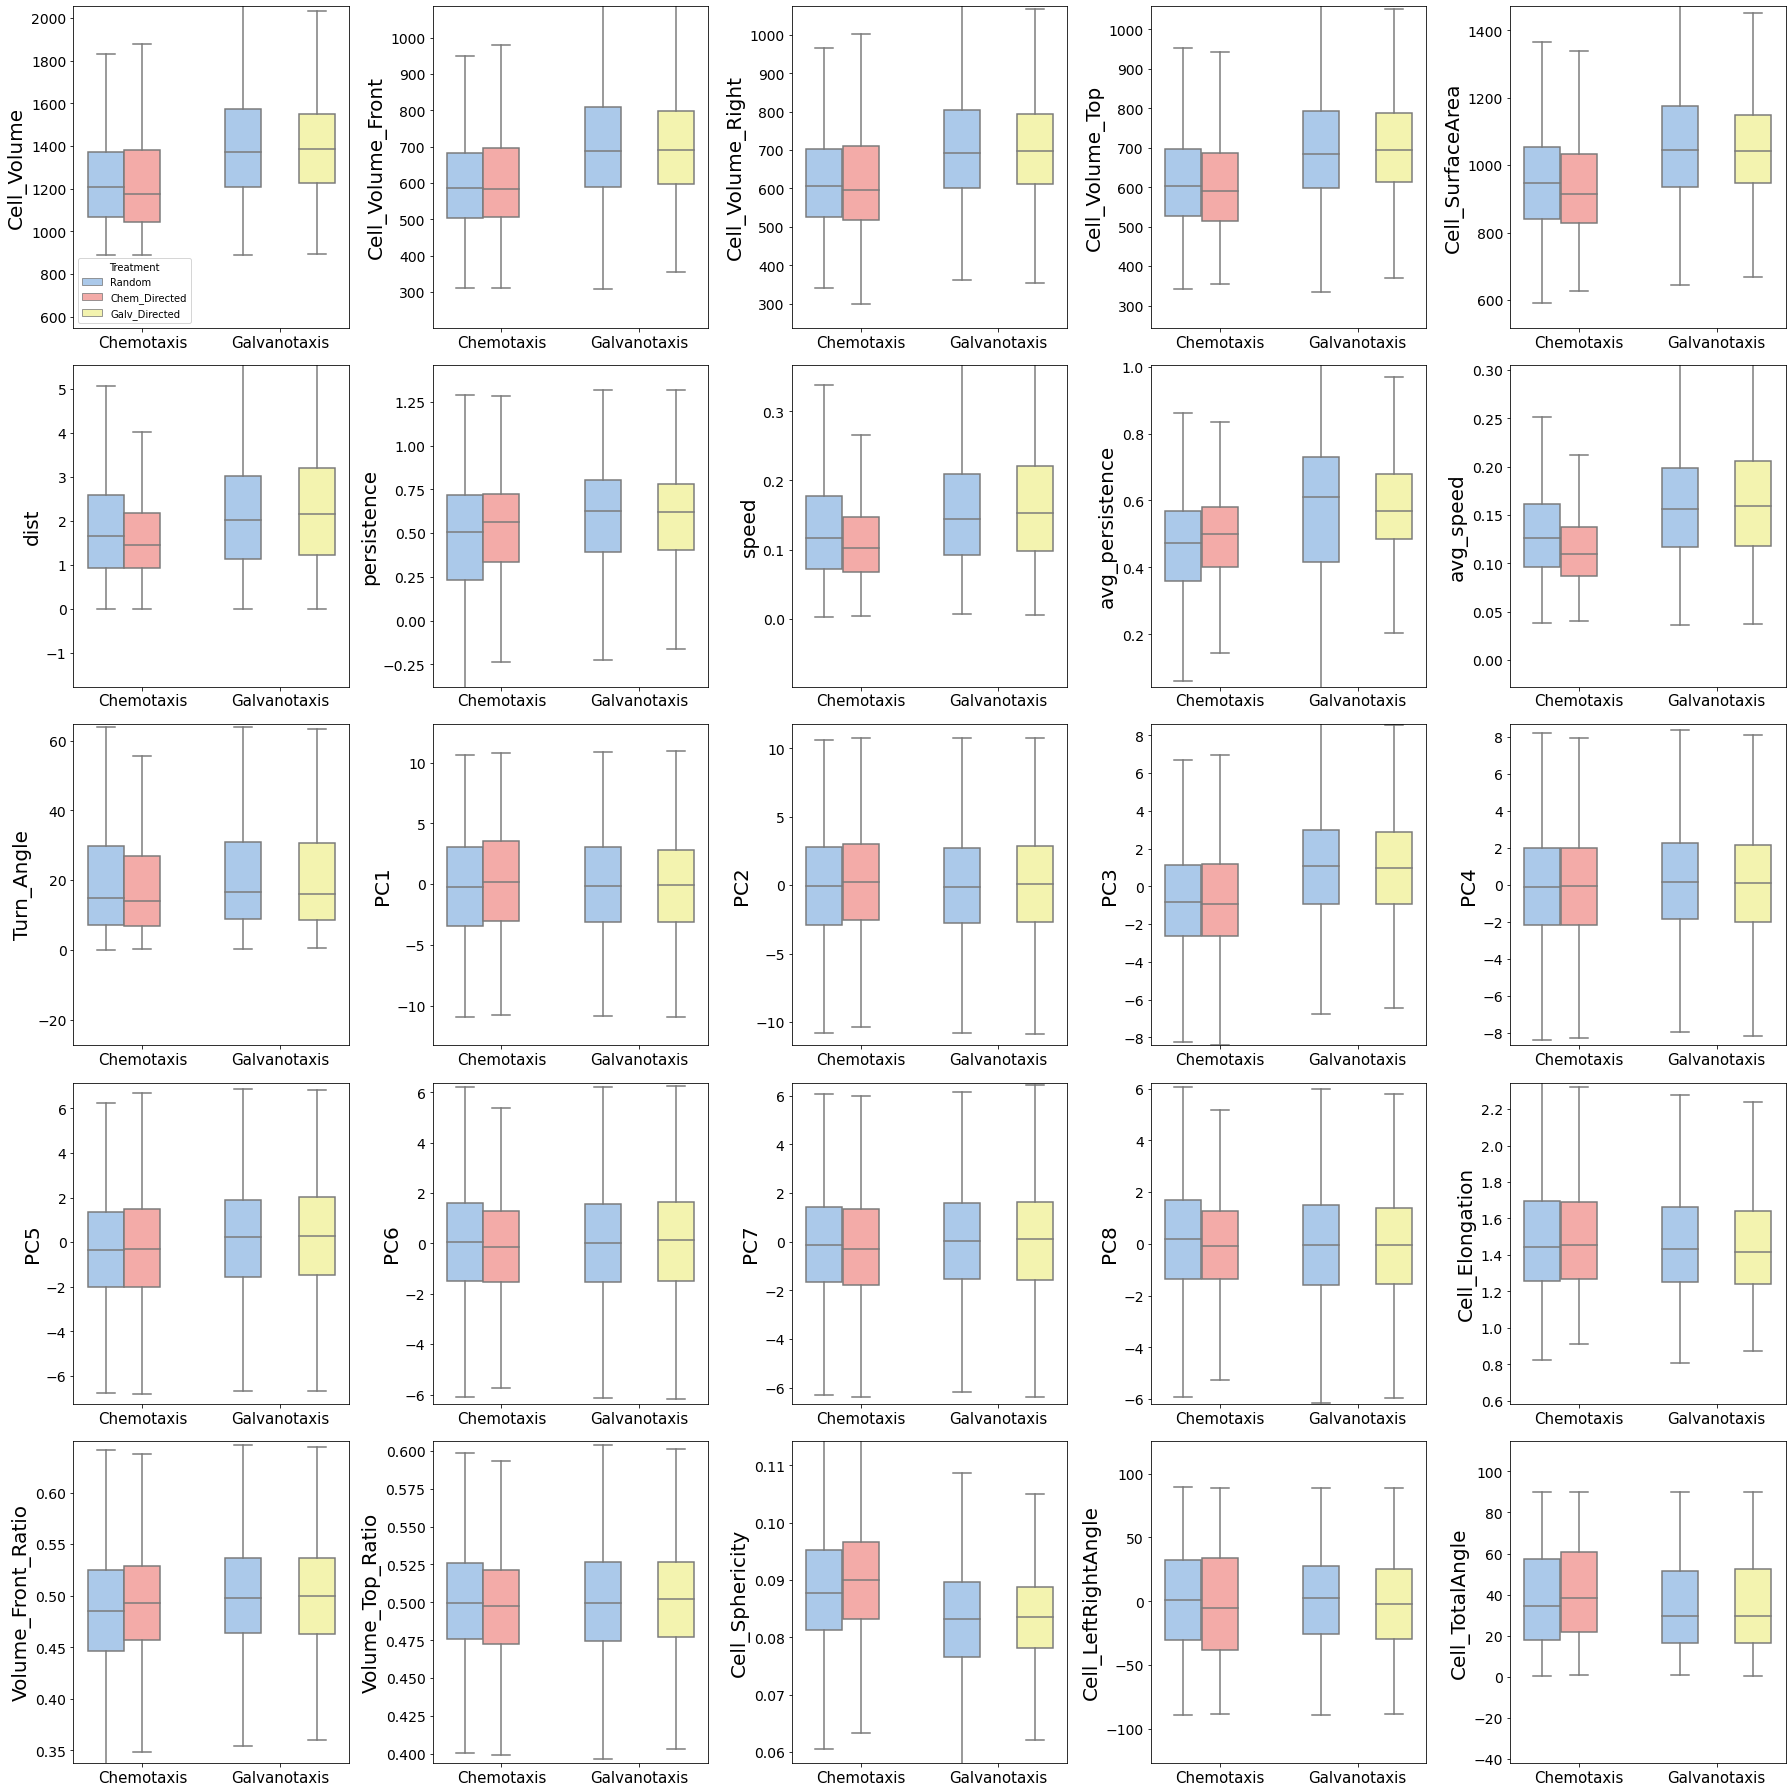

In [32]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation',
              'Volume_Front_Ratio','Volume_Right_Ratio','speed','persistence',
             'Turn_Angle', 'Cell_TotalAngle','Angular_Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell_Elongation (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Right-Left Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)', 'Cell_TotalAngle (°)','Angular Bias (°)']

#make subplots
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]
sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))
for i, ax in enumerate(axes.flatten()):
    if i<len(siglist):
        sig = siglist[i]
        bp = sns.boxplot(data=ModeFrame, x='Experiment', y=sig, hue = 'Treatment', palette = colorlist,# width = 0.15, 
                fliersize=0, boxprops={'zorder': 2}, ax=ax)
        Q1 = ModeFrame[sig].quantile(0.25)
        Q3 = ModeFrame[sig].quantile(0.75)  
        IQR = Q3 - Q1
        ax.set_ylim(Q1 - 1.6*IQR, Q3 + 1.6*IQR)
        ax.set_ylabel(sig, fontsize=20)
        ax.set_xlabel('', fontsize=20)
        ax.tick_params('y', labelsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
        if i>0:
            ax.legend_ = None
    else:
        ax.remove()

    
plt.tight_layout()
plt.savefig(datadir + 'Treatment and Experiment comparison significant metric boxes.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




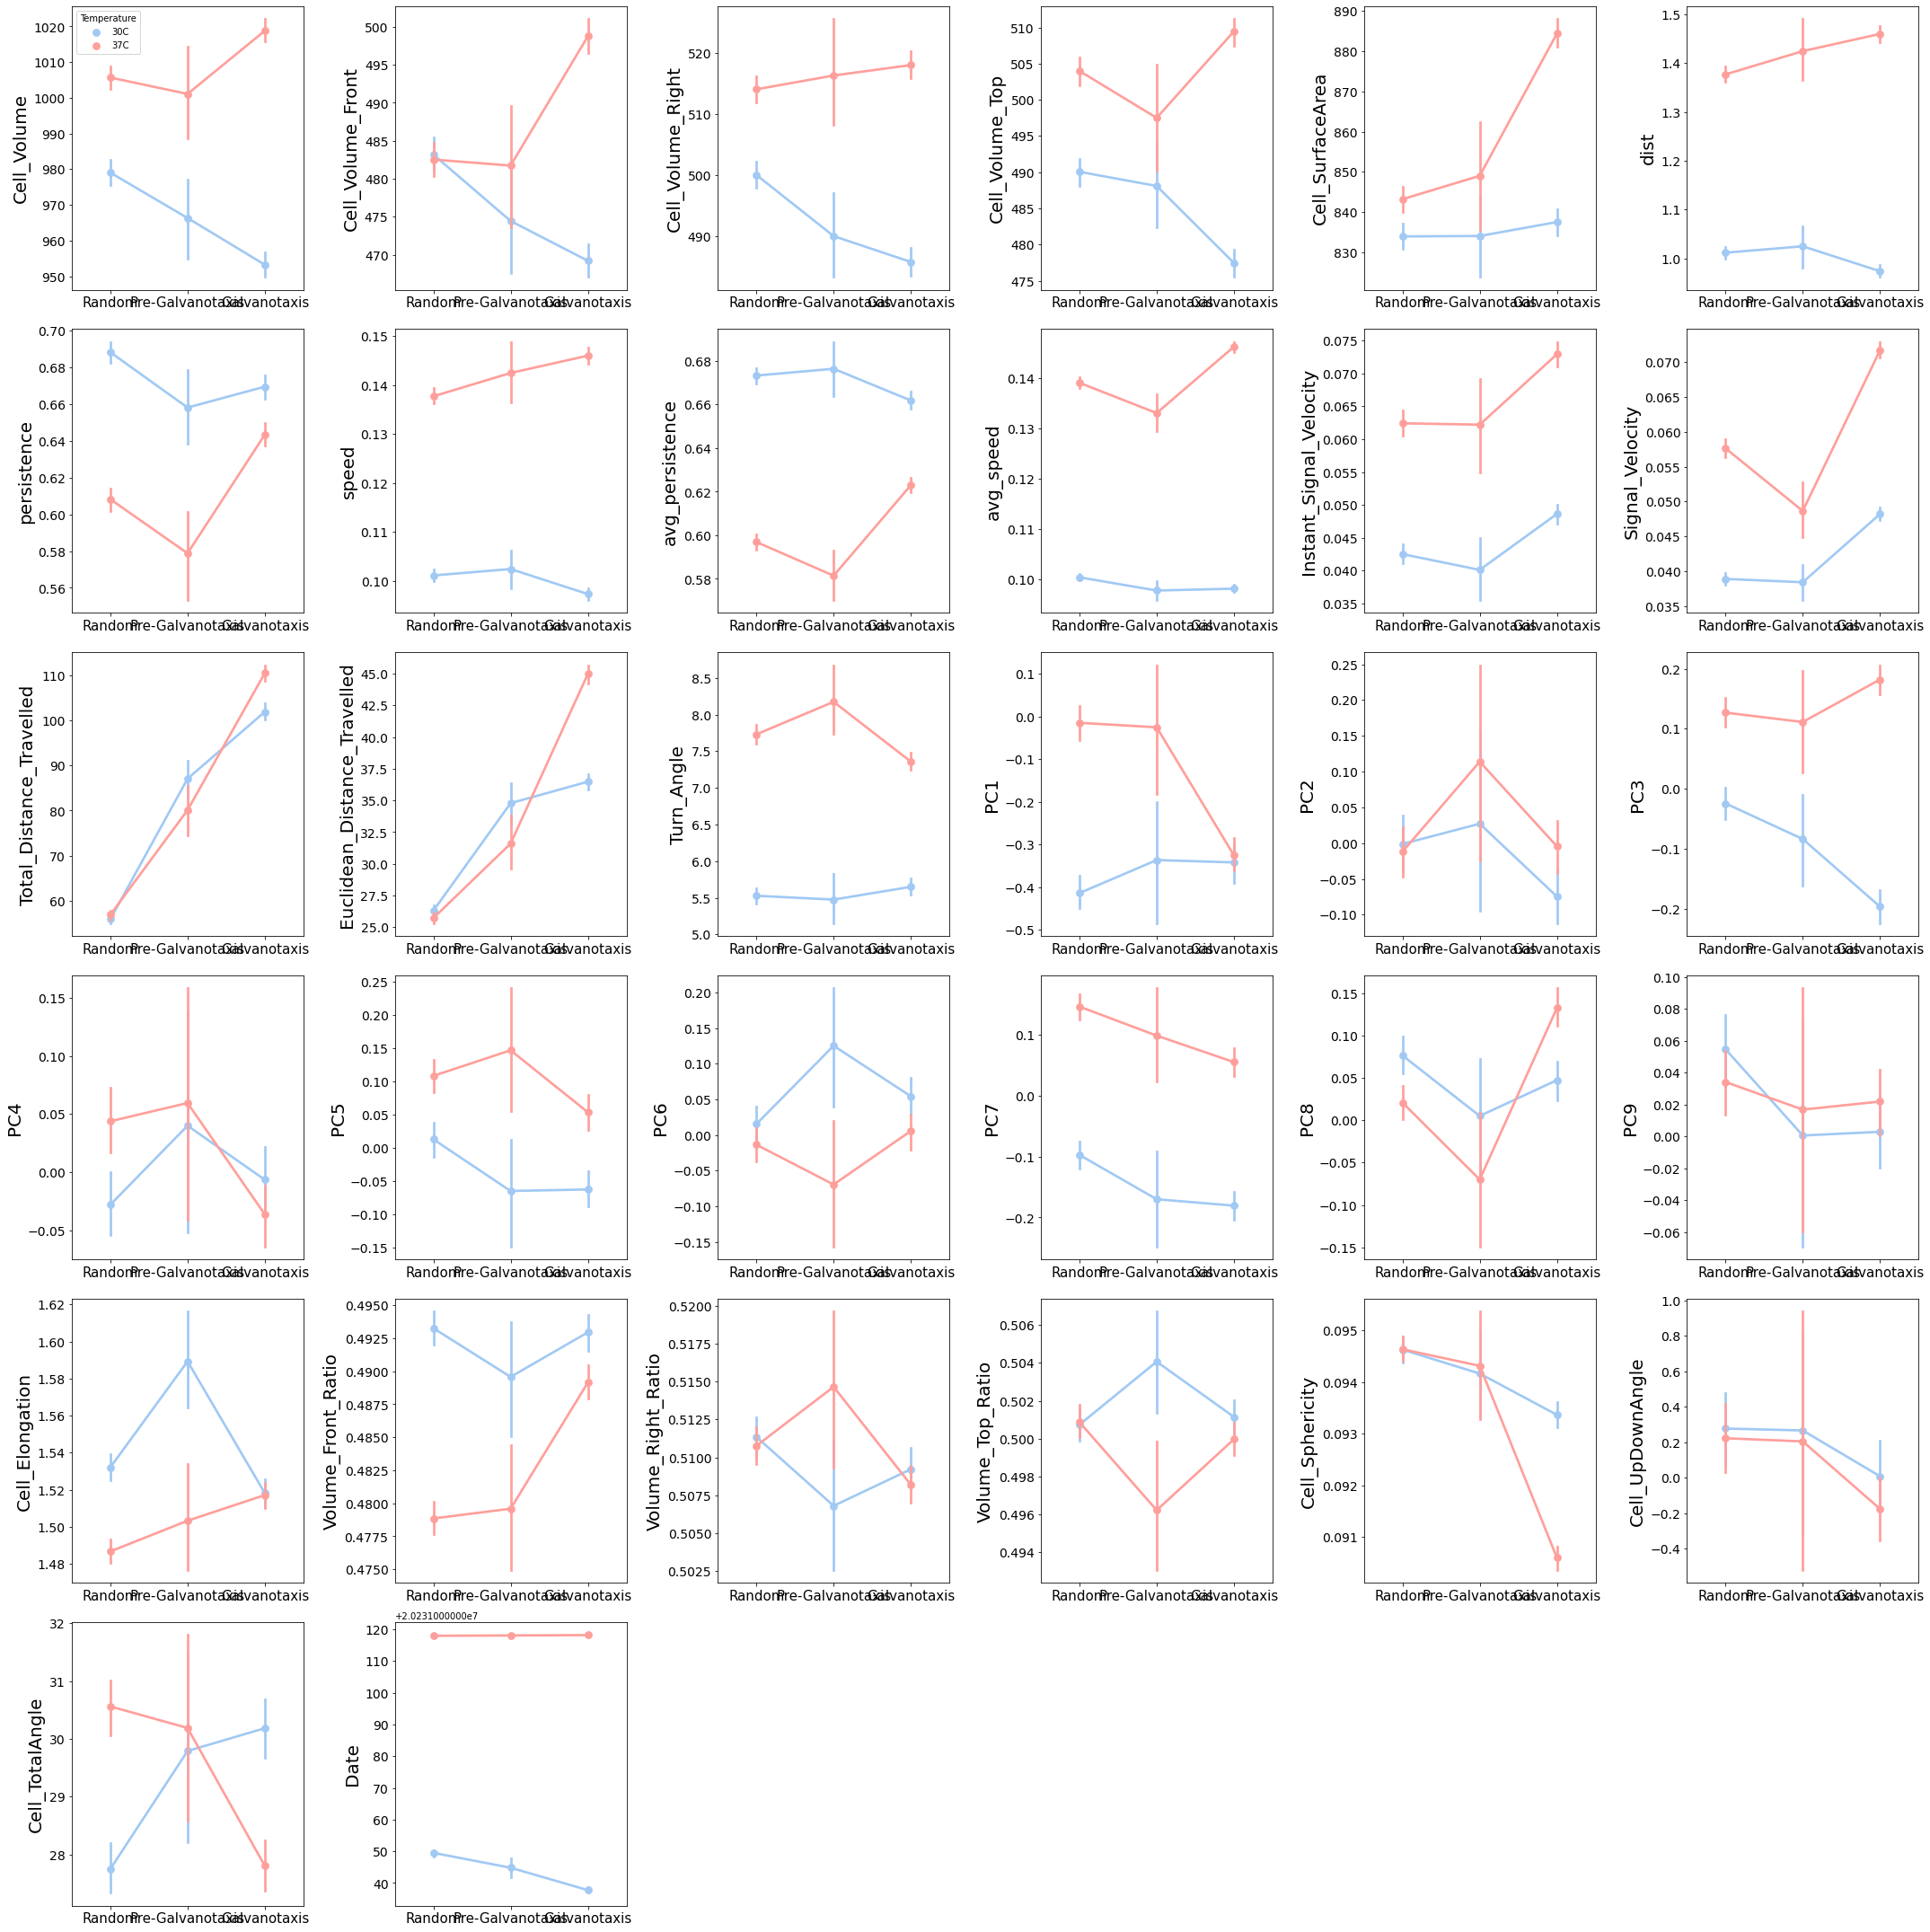

In [14]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation',
              'Volume_Front_Ratio','Volume_Right_Ratio','speed','persistence',
             'Turn_Angle', 'Cell_TotalAngle','Angular_Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell_Elongation (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Right-Left Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)', 'Cell_TotalAngle (°)','Angular Bias (°)']

sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*5,sp*5))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(siglist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.pointplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist,# width = 0.15, 
            errorbar = ('sd',1), ax=axli[i])
#     Q1 = tempframe[sig].quantile(0.25)
#     Q3 = tempframe[sig].quantile(0.75)  
#     IQR = Q3 - Q1
#     axli[i].set_ylim(Q1 - 1.6*IQR, Q3 + 1.6*IQR)
    axli[i].set_ylabel(siglist[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(datadir + 'Temperature comparison significant metric points.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




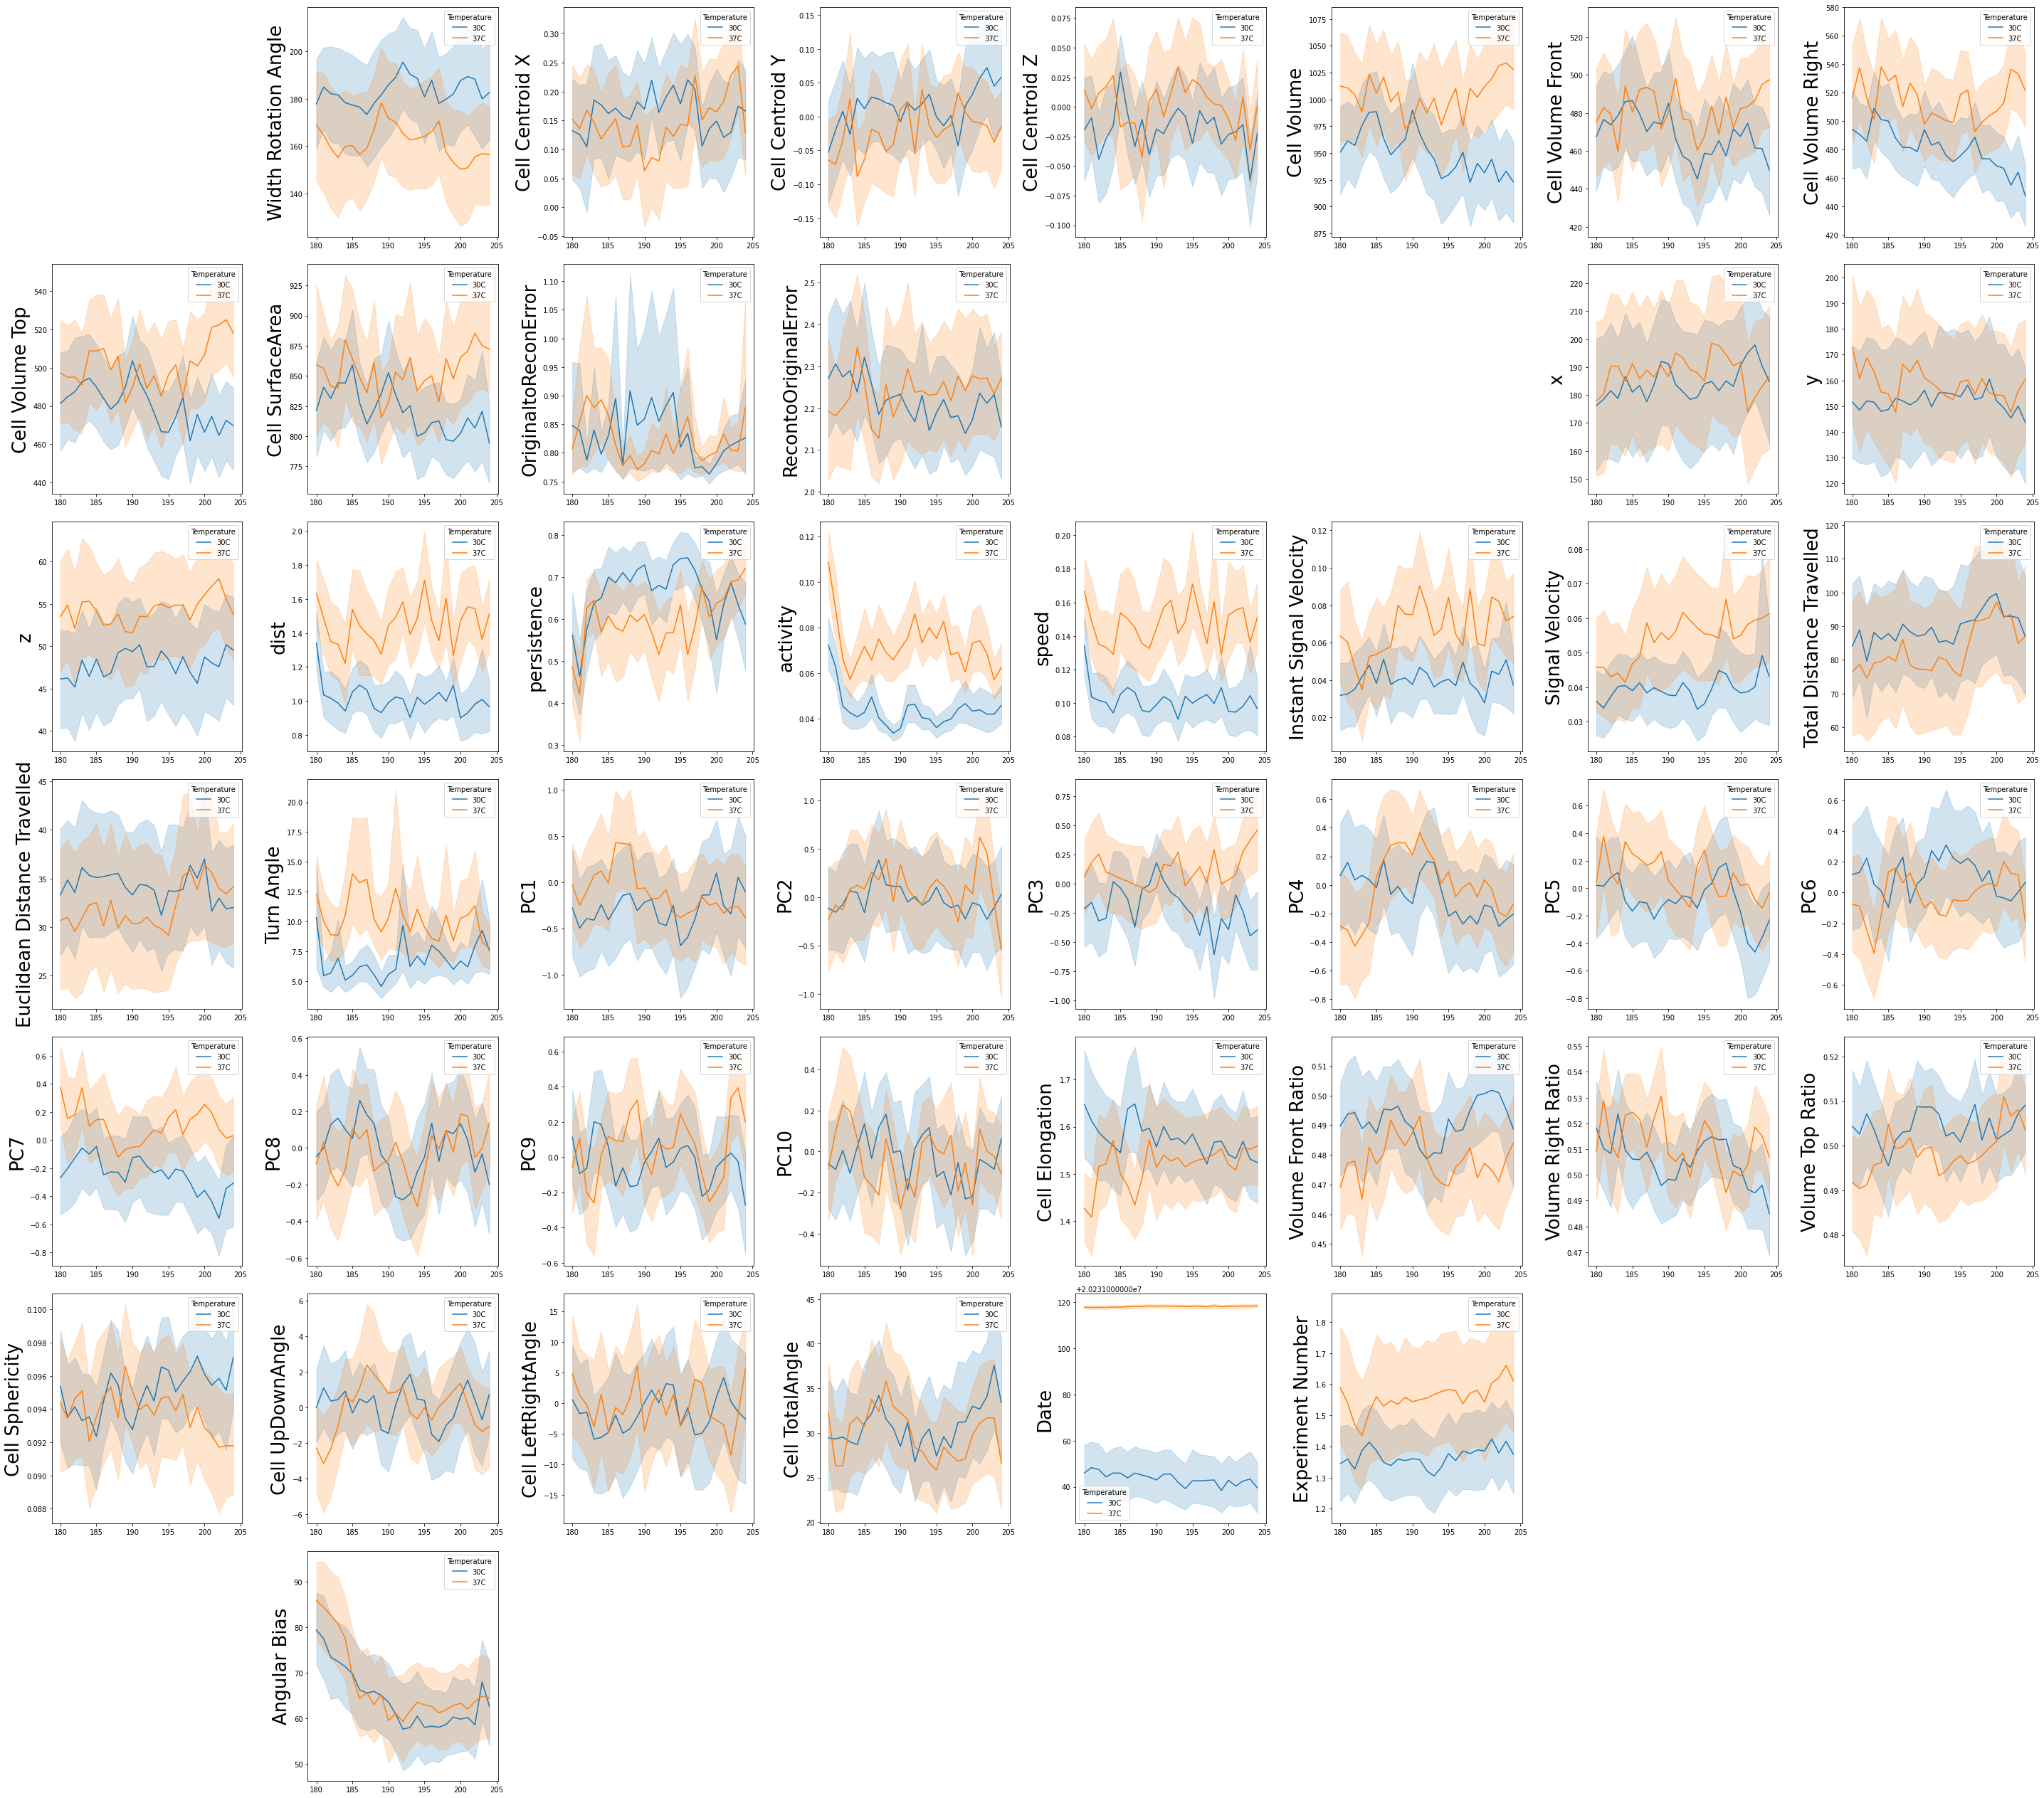

In [7]:
################### WHAT ABOUT JUST LOOKING AT PRE-GALVANOTAXIS OVER TIME ###################


############## graph all of the stats for 30C ###########
moreremove = []
moreremove.extend([i for i in TotalFrame.columns.to_list() if 'Euler' in i])
moreremove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
moreremove.extend([i for i in TotalFrame.columns.to_list() if 'avg' in i])
moreremove.extend(['cell','CellID'])
ModeFrame = TotalFrame[TotalFrame.Treatment == 'Pre-Galvanotaxis'].copy().drop(columns=to_remove+moreremove).reset_index()
#make subplots
sp = math.ceil(math.sqrt(len(ModeFrame.columns)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))
axf = axes.flatten()
for i, param in enumerate(ModeFrame.columns.to_list()):
    ax = axf[i]
    if param not in ['frame', 'Treatment','Experiment','Temperature','structure','index']:
    #### use the max and the lowest non zero as min
        sns.lineplot(data = ModeFrame,
            x = 'frame',
            y = param,
            hue = 'Temperature',
            ax = ax,
        )
#         ax.set_xticklabels(
#             [round(x,1) for x in centers.PC1.to_list()],
#             fontsize = 22
#         )
#         ax.set_yticklabels(
#             [round(x,1) for x in centers.PC2.to_list()],
#             rotation=0,
#             fontsize = 22
#         )
#         #take out all axis labels except the desired ones
#         for o, l in enumerate(ax.xaxis.get_ticklabels()):
#             if o%5 != 0:
#                 l.set_visible(False)
#         for o, l in enumerate(ax.yaxis.get_ticklabels()):
#             if o%5 != 0:
#                 l.set_visible(False)
            #set axis titles
        ax.set_xlabel('')
        ax.set_ylabel(param.replace('_',' '), fontsize = 26)
    else:
        ax.remove()
for a in range(i+1,len(axf)):
    axf[a].remove()
    
    
plt.tight_layout()


In [ ]:
################### WHAT ABOUT JUST LOOKING AT EVERYTHING AFTER EF OVER TIME ###################


############## graph all of the stats for 30C ###########
moreremove = []
moreremove.extend([i for i in TotalFrame.columns.to_list() if 'Euler' in i])
moreremove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
moreremove.extend([i for i in TotalFrame.columns.to_list() if 'avg' in i])
moreremove.extend(['cell','CellID'])
ModeFrame = TotalFrame[TotalFrame.Treatment.isin(['Pre-Galvanotaxis','Galvanotaxis'])].copy().drop(columns=to_remove+moreremove).reset_index()
#make subplots
sp = math.ceil(math.sqrt(len(ModeFrame.columns)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))
axf = axes.flatten()
for i, param in enumerate(ModeFrame.columns.to_list()):
    ax = axf[i]
    if param not in ['frame', 'Treatment','Experiment','Temperature','structure','index']:
    #### use the max and the lowest non zero as min
        sns.lineplot(data = ModeFrame,
            x = 'frame',
            y = param,
            hue = 'Temperature',
            ax = ax,
        )
#         ax.set_xticklabels(
#             [round(x,1) for x in centers.PC1.to_list()],
#             fontsize = 22
#         )
#         ax.set_yticklabels(
#             [round(x,1) for x in centers.PC2.to_list()],
#             rotation=0,
#             fontsize = 22
#         )
#         #take out all axis labels except the desired ones
#         for o, l in enumerate(ax.xaxis.get_ticklabels()):
#             if o%5 != 0:
#                 l.set_visible(False)
#         for o, l in enumerate(ax.yaxis.get_ticklabels()):
#             if o%5 != 0:
#                 l.set_visible(False)
            #set axis titles
        ax.set_xlabel('')
        ax.set_ylabel(param.replace('_',' '), fontsize = 26)
    else:
        ax.remove()
for a in range(i+1,len(axf)):
    axf[a].remove()
    
    
plt.tight_layout()


In [4]:
##################### RENDERING THE AVERAGE CELL FOR EACH TREATMENT GROUP ##############
#open the coefficients and match them with the current dataset and treatment labels
shframe = pd.read_csv(datadir + 'Shape_Metrics_with_Digitized_PCs.csv', index_col=0)
coeff_df = shframe.loc[shframe.cell.isin(TotalFrame.cell),[x for x in shframe.columns.to_list() if 'shcoeffs' in x or 'cell' in x]].copy()
coeff_df = coeff_df.merge(TotalFrame[['cell','Temperature','Treatment']], left_on = 'cell', right_on = 'cell')

#load reconstruction functions
from CustomFunctions.shtools_mod import get_reconstruction_from_coeffs, save_polydata

#make the save directory if you haven't yet
avgcelldir = datadir + 'Average_Treatment_Reconstructions/'
if not os.path.exists(avgcelldir):
    os.makedirs(avgcelldir)

#get the reconstructions for the average coefficients of each unique treatment and temperature combo
for te in coeff_df.Temperature.unique():
    for tr in coeff_df.Treatment.unique():
        avgcoeffs = coeff_df.loc[(coeff_df.Temperature == te) & (coeff_df.Treatment == tr)][[x for x in coeff_df.columns.to_list() if 'shcoeffs' in x]].mean().values
        mesh, grid = get_reconstruction_from_coeffs(avgcoeffs.reshape(2,lmax+1,lmax+1),
                                                   lmax)
        save_polydata(mesh, avgcelldir + f'{tr} {te} Average Reconstruction.vtk')


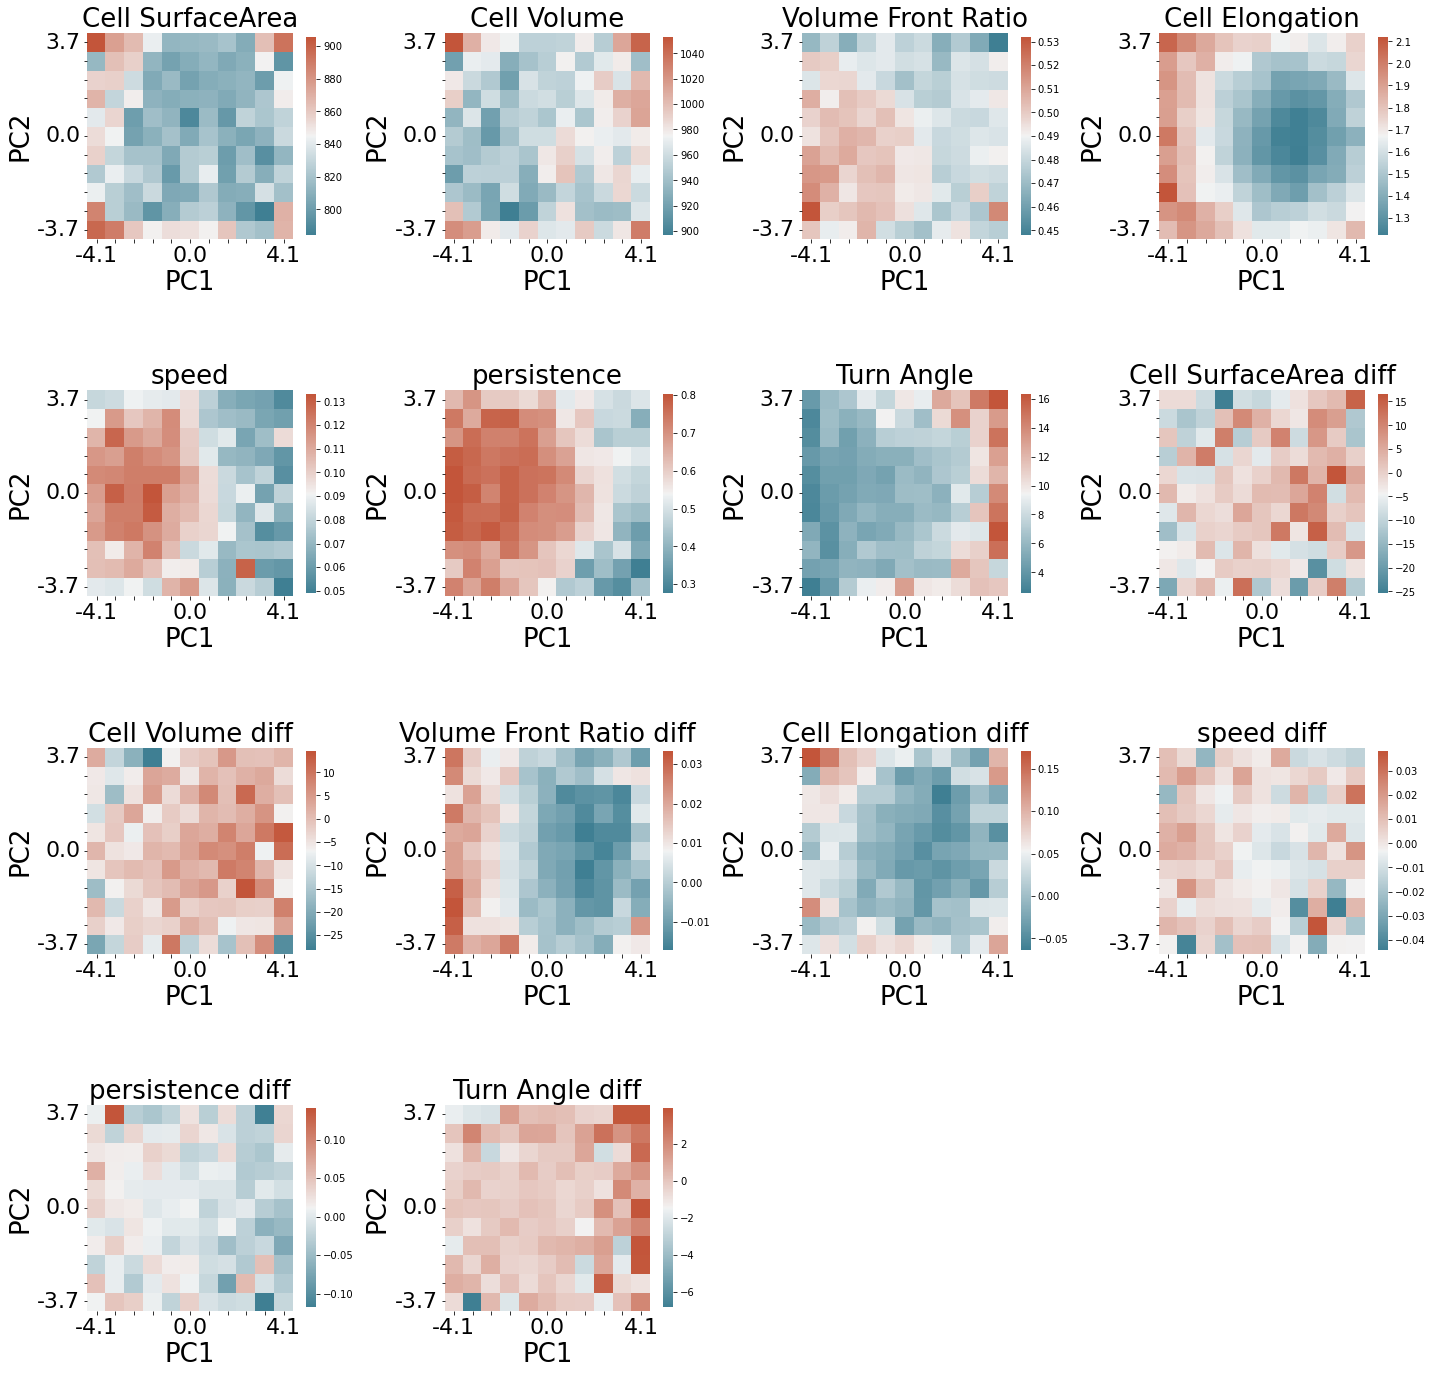

In [11]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 22
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC2.to_list()],
            rotation=0,
            fontsize = 22
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i].replace('_',' '), fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

In [ ]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRIC DIFFERENTIALS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(metrics):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[metrics[i]]
                else:
                    bighm[y,x] = current[metrics[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(metrics[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

NameError: name 'cbar_ax' is not defined

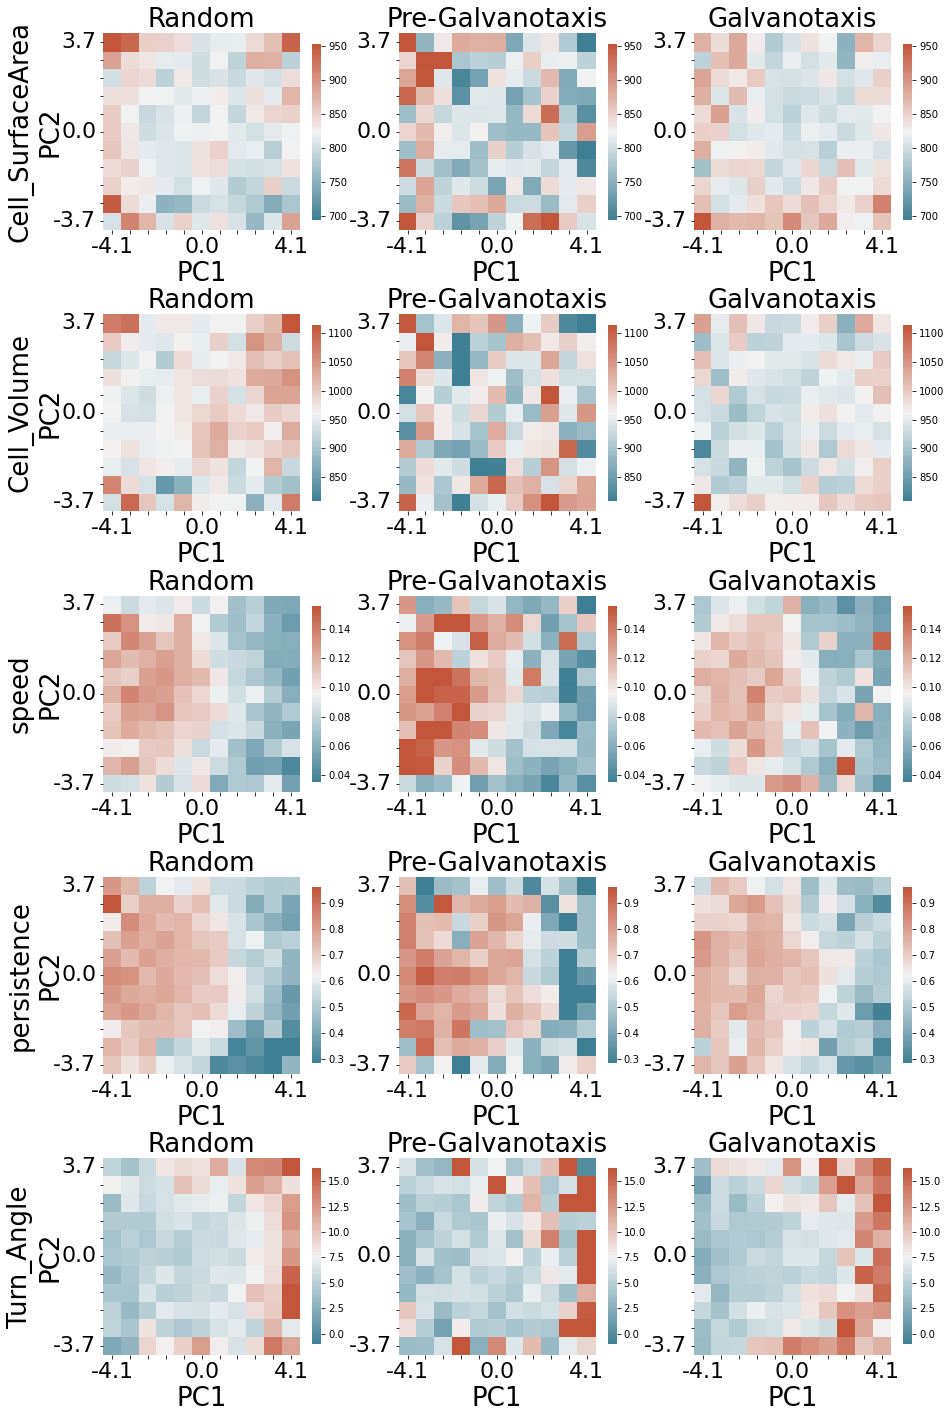

In [10]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(len(metrics),len(TotalFrame.Treatment.unique()),figsize=(15,len(metrics)*5))


for i, met in enumerate(metrics):
    for a, ax in enumerate(axes[i]):
        mm = TotalFrame.Treatment.unique()[a]
        mdf = TotalFrame[TotalFrame.Treatment==mm]
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((len(axes[i]),nbins,nbins))
        for n in range(bighm.shape[0]):
            mdf = TotalFrame[TotalFrame.Treatment==TotalFrame.Treatment.unique()[n]]
            for x in range(nbins):
                for y in range(nbins):
                    current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC2bins'] == y+1)].dropna(subset=[met])
                    if current.empty:
                        bighm[n,y,x] = 0
                    elif len(current)==1:
                        bighm[n,y,x] = current[met]
                    else:
                        bighm[n,y,x] = current[met].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm[a,:,:],
            vmin=np.mean(bighm[np.nonzero(bighm)])-(bighm.std()*2),
            vmax=np.mean(bighm)+(bighm.std()*2), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.75}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 22
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC2.to_list()],
            rotation=0,
            fontsize = 22
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)      
        if (a == 0):
            ax.set_ylabel(f'{met}\nPC2', fontsize = 26, labelpad=-10)
#         else:
#             ax.set_ylabel(f'PC2', fontsize = 26, labelpad=-10)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps separated.png', bbox_inches='tight')

In [19]:
len(PCsAndMetrics.columns)

48

In [20]:
savedir

'D:/Aaron/Data/Chem_Galv_Combined/'